**Name: Mauyresh Rajesh Dindorkar**  
**Roll No.: CS23MTECH14007**  
**Deep Learning Assignment No. 3**  
---

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
from operator import itemgetter
from torch.utils.data import DataLoader
import math
import time

**Utility Functions:**

In [2]:
# Counts number of samples in each class
def count_classwise_label_count(train_dataset, test_dataset):
    train_labels = set()
    train_dict = {}
    for _, label in train_dataset:
        train_labels.add(label)
        if label not in train_dict:
            train_dict[label] = 1
        else:
            train_dict[label] = train_dict[label] + 1
    print("-" * 50)
    print("All labels available in Train set:", train_labels)
    train_dict = dict(sorted(train_dict.items(), key=itemgetter(0)))
    print("Train labels Count:", train_dict)
    print("-" * 50)

    test_labels = set()
    test_dict = {}
    for _, label in test_dataset:
        test_labels.add(label)
        if label not in test_dict:
            test_dict[label] = 1
        else:
            test_dict[label] = test_dict[label] + 1
    print("All labels available in Test set:", test_labels)
    test_dict = dict(sorted(test_dict.items(), key=itemgetter(0)))
    print("Test labels Count:", test_dict)

In [3]:
# Plot epoch Vs loss graph
def plot_epoch_vs_loss(epochs, losses, title):
    plt.plot(epochs, losses, label="Training Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def get_transform_for_dataset():
    return Compose([
        transforms.ToTensor()
    ])

In [5]:
def plot_img_in_subplot(axis, row, col, img, label, classes_dict):
    axs[row, col].imshow(img)
    axs[row, col].set_title("Label: " + classes_dict[label])
    axs[row, col].axis("off")

In [6]:
def fit_model(model, train_loader, optimizer, loss_function, epochs):
    loss_list = []
    ep = 0
    model.train()
    while ep < epochs:
        batch_loss_list = []
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = loss_function(outputs, labels)
            loss.backward()
            
            optimizer.step()
            batch_loss_list.append(loss.item())
        
        loss_list.append(sum(batch_loss_list) / len(train_loader))
        print("Epoch {}, Loss = {}".format(ep + 1, loss_list[-1]))
        ep = ep + 1
    return loss_list

In [7]:
def apply_row_wise_softmax(logits):
    return F.softmax(logits, dim = 1)

def calculate_classification_accuracy(correct_predictions, total_no_of_samples):
    return (correct_predictions / total_no_of_samples) * 100

def calculate_accuracy(model, data_loader, title):
    correct_predictions = 0
    model.eval()
    total_no_of_samples = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            batch_of_images, target_labels = batch
            batch_of_images = batch_of_images.to(device)
            target_labels = target_labels.to(device)
            
            output_logits = model(batch_of_images)
            pred_probabilities = apply_row_wise_softmax(output_logits)
            _, predicted_labels = torch.max(pred_probabilities, 1)
            
            total_no_of_samples = total_no_of_samples + target_labels.size(0)
            correct_predictions = correct_predictions + ((predicted_labels == target_labels).sum().item())

    print(title, calculate_classification_accuracy(correct_predictions, total_no_of_samples), ' %')

---
**Downloading the Original dataset:**

In [8]:
train_dataset = CIFAR10(root='./cifar10_dataset', train=True, download=True, transform=get_transform_for_dataset())
test_dataset = CIFAR10(root='./cifar10_dataset', train=False, download=True, transform=get_transform_for_dataset())

100%|██████████| 170498071/170498071 [00:03<00:00, 43720882.22it/s]


Extracting ./cifar10_dataset/cifar-10-python.tar.gz to ./cifar10_dataset
Files already downloaded and verified


**Original Dataset Statistics:**

In [9]:
print("Number of images in the Original CIFAR-10 Train set:", len(train_dataset))
print("Number of images in the Original CIFAR-10 Test set:", len(test_dataset))

Number of images in the Original CIFAR-10 Train set: 50000
Number of images in the Original CIFAR-10 Test set: 10000


In [10]:
print('Original CIFAR-10 dataset label stats:')
count_classwise_label_count(train_dataset, test_dataset)

Original CIFAR-10 dataset label stats:
--------------------------------------------------
All labels available in Train set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Train labels Count: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
--------------------------------------------------
All labels available in Test set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Test labels Count: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


**Printing the labels:**  
These labels values corresponds to labels: ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

In [11]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

**Creating data loaders for Train and Test datasets:**

In [12]:
train_dataset_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)
print('Number of train batches:', len(train_dataset_loader))
print('Number of test batches:', len(test_dataset_loader))

Number of train batches: 1563
Number of test batches: 313


**Checking GPU availability:**

In [13]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('Model will get trained on:', device)

Model will get trained on: cuda


**Printing a 10 random samples from the dataset:**

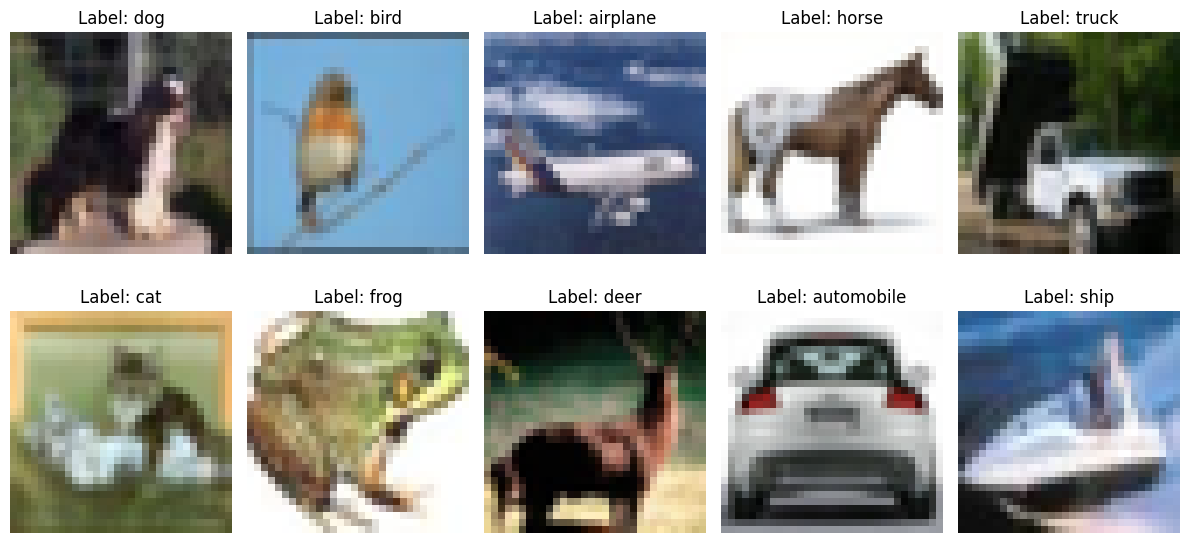

In [14]:
seen_categories = set()
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
row = 0
col = 0
for images, labels in train_dataset_loader:
    for image, label in zip(images, labels):
        category = train_dataset.classes[label.item()]
        if category not in seen_categories:
            seen_categories.add(category)

            image_np = np.transpose(image.squeeze().numpy(), (1, 2, 0))
            plot_img_in_subplot(axs, row, col, image_np, label.item(), train_dataset.classes)
            col = col + 1
            
            if col == 5:
                col = 0
                row = 1
    if len(seen_categories) == len(train_dataset.classes):
        break
plt.tight_layout()
plt.show()

---

**Q1) Self-Attention for Object Recognition with CNNs:**  
Architecture of self attention layer is referred from the classroom PPT:  
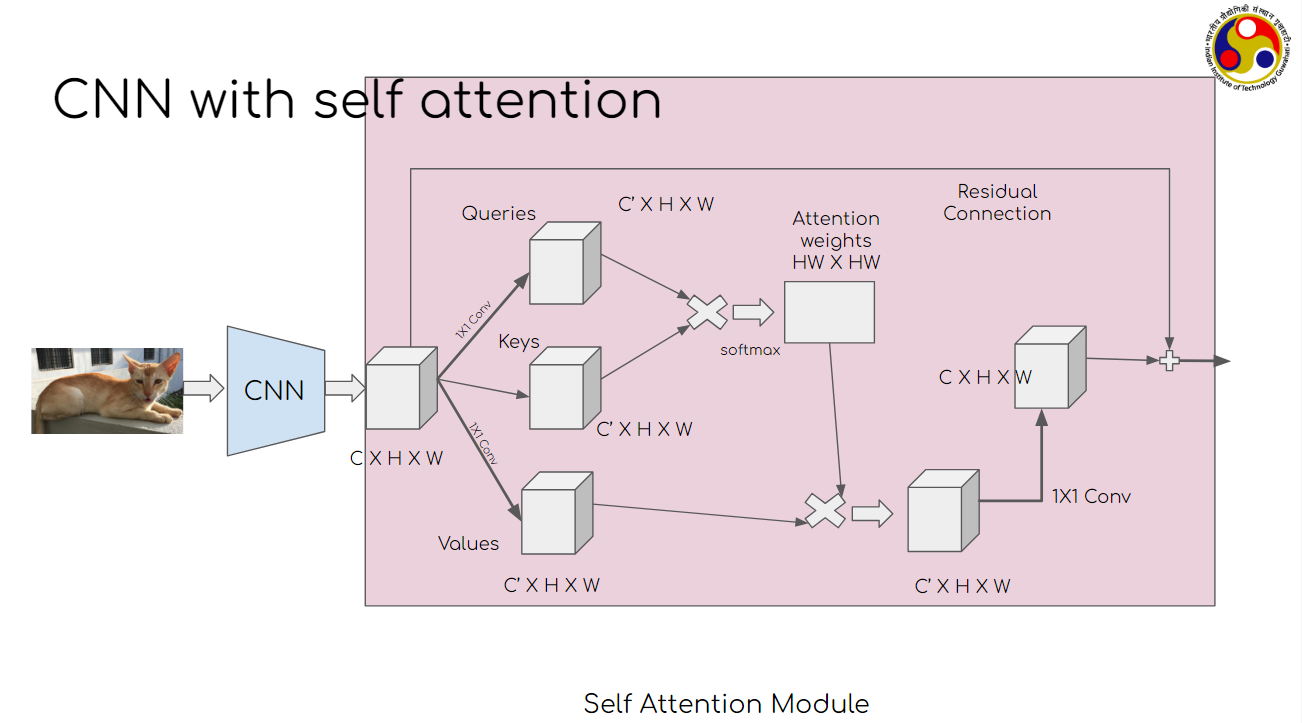

**Formulae used for attention calculation:** Reference classroom PPT  
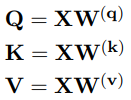  
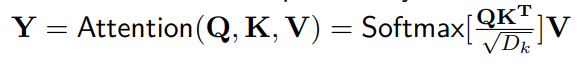

In [15]:
class Self_Attention_Layer(nn.Module):
    def __init__(self, in_dim):
        super(Self_Attention_Layer, self).__init__()
        self.in_dim = in_dim
        self.D = math.floor(in_dim / 8)
        self.W_q = nn.Conv2d(in_channels = self.in_dim, out_channels = self.D, kernel_size=1)
        self.W_k = nn.Conv2d(in_channels = self.in_dim, out_channels = self.D, kernel_size=1)
        self.W_v = nn.Conv2d(in_channels = self.in_dim, out_channels = self.in_dim, kernel_size=1)
        self.reduction_factor = nn.Parameter(torch.zeros(1))
        
    def extract_input_dimensions(self, x):
        self.batch_size = x.shape[0]
        self.channels = x.shape[1]
        self.height = x.shape[2]
        self.width = x.shape[3]
        
    def calculate_query_key_value_matrices(self, x):
        D = self.width * self.height
        Q = self.W_q(x).view(self.batch_size, -1, D).permute(0, 2, 1)
        V = self.W_v(x).view(self.batch_size, -1, D)
        K = self.W_k(x).view(self.batch_size, -1, D)
        return Q, K, V
    
    def scale_the_attention(self, K, Q_K):
        sqrt_dk = torch.sqrt(torch.tensor(K.size(-1), dtype=torch.float32))
        Q_K_scaled = Q_K / sqrt_dk
        return Q_K_scaled
    
    def apply_softmax(self, a):
        return F.softmax(a, dim=-1)
    
    def residual_connection(self, out, x):
        return (self.reduction_factor * out) + x
        
    def forward(self, x):
        self.extract_input_dimensions(x)
        Q, K, V = self.calculate_query_key_value_matrices(x)
        Q_K = torch.bmm(Q, K)

        # Scaling the attention
        Q_K_scaled = self.scale_the_attention(K, Q_K)
        
        # Applying softmax
        Q_K_softmax = self.apply_softmax(Q_K_scaled)

        out = torch.bmm(V, Q_K_softmax.permute(0, 2, 1))
        out = out.view(self.batch_size, self.channels, self.height, self.width)

        # Applying Residual connection
        return self.residual_connection(out, x)

In [16]:
class Custom_CNN_With_SelfAttention(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(Custom_CNN_With_SelfAttention, self).__init__()
        
        self.conv_layer_0 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.self_attention_layer_0 = Self_Attention_Layer(64)
        
        self.conv_layer_1 = nn.Conv2d(64, 92, kernel_size=3, stride=1, padding=1)
        self.dropout_layer_1 = nn.Dropout(p = dropout_rate)
        self.self_attention_layer_1 = Self_Attention_Layer(92)
        
        self.conv_layer_2 = nn.Conv2d(92, 128, kernel_size=3, stride=1, padding=1)
        self.dropout_layer_2 = nn.Dropout(p = dropout_rate)
        self.self_attention_layer_2 = Self_Attention_Layer(128)
        
        self.conv_layer_3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.self_attention_layer_3 = Self_Attention_Layer(256)
        
        self.conv_layer_4 = nn.Conv2d(256, 400, kernel_size=3, stride=1, padding=1)
        self.dropout_layer_4 = nn.Dropout(p = dropout_rate)
        self.self_attention_layer_4 = Self_Attention_Layer(400)
        
        self.conv_layer_5 = nn.Conv2d(400, 10, kernel_size=3, stride=1, padding=1)
        self.global_avg_pooling_layer = nn.AdaptiveAvgPool2d(1)
        
    def activation_function(self, a):
        return F.relu(a)

    def forward(self, x):
        x = self.conv_layer_0(x)
        x = self.activation_function(x)
        x = self.self_attention_layer_0(x)
        
        x = self.conv_layer_1(x)
        x = self.activation_function(x)
        x = self.dropout_layer_1(x)
        x = self.self_attention_layer_1(x)
        
        x = self.conv_layer_2(x)
        x = self.activation_function(x)
        x = self.dropout_layer_2(x)
        x = self.self_attention_layer_2(x)
        
        x = self.conv_layer_3(x)
        x = self.activation_function(x)
        x = self.self_attention_layer_3(x)
        
        x = self.conv_layer_4(x)
        x = self.activation_function(x)
        x = self.dropout_layer_4(x)
        x = self.self_attention_layer_4(x)
        
        x = self.global_avg_pooling_layer(self.conv_layer_5(x))
        x = x.view(-1, 10)
        return x

**Training the custom CNN model:**

Epoch 1, Loss = 1.8930156018897195
Epoch 2, Loss = 1.5213303984698774
Epoch 3, Loss = 1.3784445070411941
Epoch 4, Loss = 1.2808680121363238
Epoch 5, Loss = 1.2077960391419862
Epoch 6, Loss = 1.147376172792736
Epoch 7, Loss = 1.0945372443434067
Epoch 8, Loss = 1.0538593936218181
Epoch 9, Loss = 1.0153455463496066
Epoch 10, Loss = 0.9840328590044667
Epoch 11, Loss = 0.952650638913315
Epoch 12, Loss = 0.9261849133425314
Epoch 13, Loss = 0.902423965381798
Epoch 14, Loss = 0.8812807659956406
Epoch 15, Loss = 0.8629633596289714
Epoch 16, Loss = 0.8452689163744336
Epoch 17, Loss = 0.8308504787550778
Epoch 18, Loss = 0.8115720663098136
Epoch 19, Loss = 0.8006113479325043
Epoch 20, Loss = 0.7862935440897255
Execution time of custom CNN: 3376.2830069065094 seconds


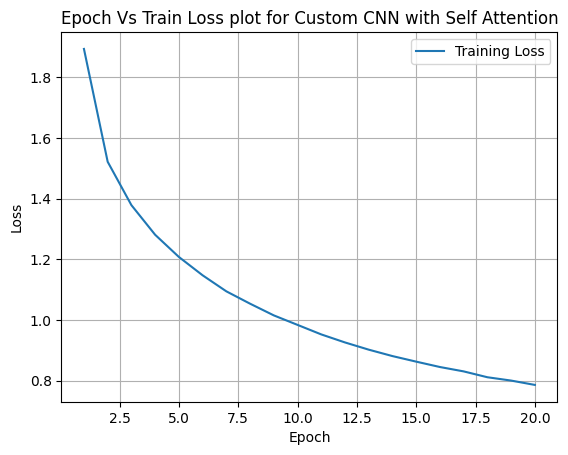

--------------------  Custom CNN performance  --------------------
Train accuracy:  73.654  %
Test accuracy:  71.3  %
------------------------------------------------------------


In [17]:
cnn_model = Custom_CNN_With_SelfAttention()
cnn_model = cnn_model.to(device)
cnn_optimizer = torch.optim.Adagrad(cnn_model.parameters(), lr=0.005)
epochs = 20
cnn_loss_function = nn.CrossEntropyLoss()

start_time = time.time()
cnn_loss_list = fit_model(model = cnn_model, train_loader = train_dataset_loader, optimizer = cnn_optimizer, 
                      loss_function = cnn_loss_function, epochs = epochs)
print(f'Execution time of custom CNN: { time.time() - start_time} seconds')
plot_epoch_vs_loss(np.arange(1, epochs + 1), cnn_loss_list, 'Epoch Vs Train Loss plot for Custom CNN with Self Attention')

print('-'*20, ' Custom CNN performance ', '-'*20)
calculate_accuracy(model = cnn_model, data_loader = train_dataset_loader, title = 'Train accuracy: ')
calculate_accuracy(model = cnn_model, data_loader = test_dataset_loader, title = 'Test accuracy: ')
print('-'*60)

---
**Q2) Object Recognition with Vision Transformer:**  
Reference: Classroom PPT  
**Encoder Layer Architecture**  
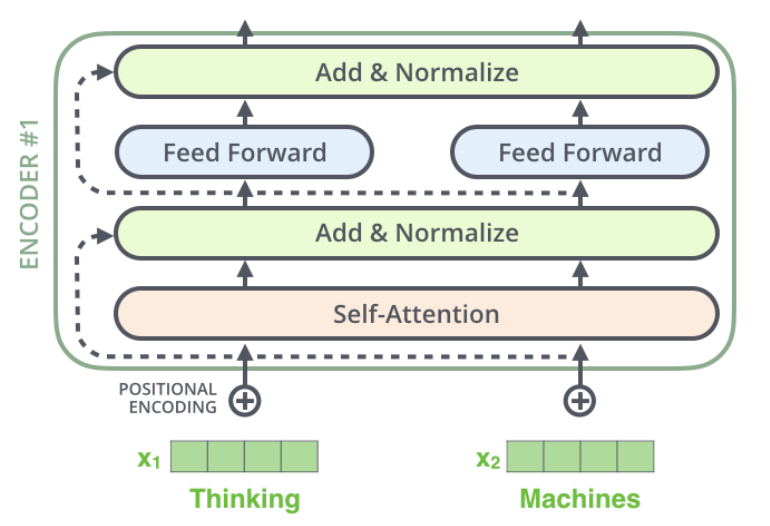  

**Vision Transformer (ViT) Architecture:**  
Reference: Classroom PPT
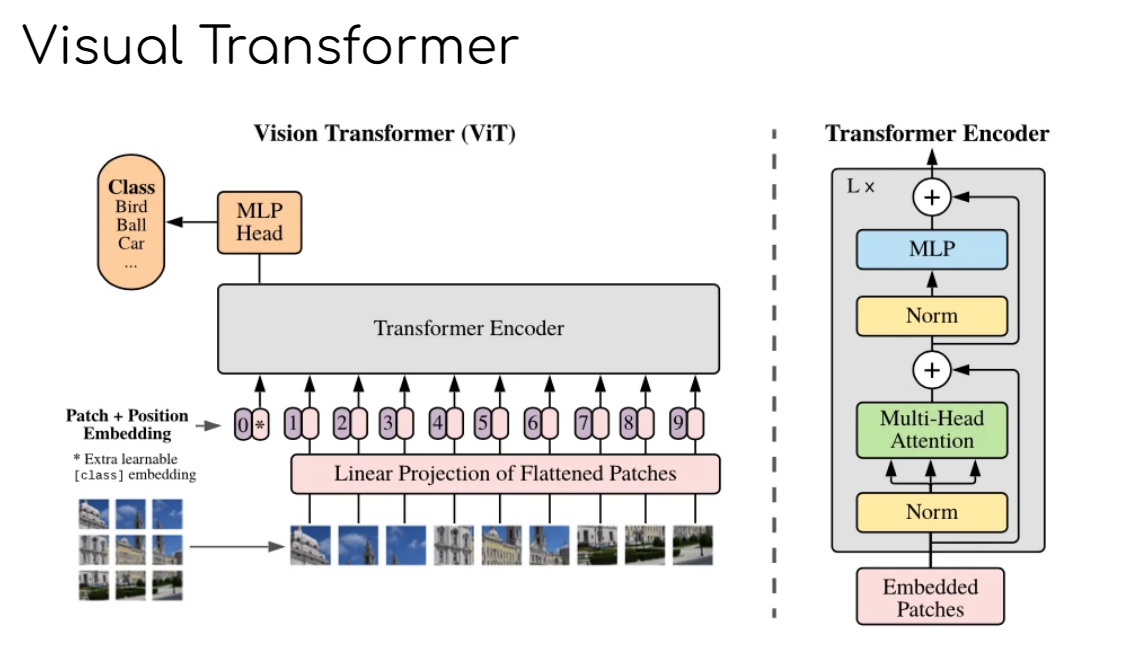

In [18]:
# Divides the image into patches and subsequently perform embedding on each of these patches.
class Create_Patches_And_Embed_Layer(nn.Module):
    def __init__(self, input_channels, size_of_image, size_of_patch, embedding_dimensions):
        super(Create_Patches_And_Embed_Layer, self).__init__()
        self.size_of_patch = size_of_patch
        self.size_of_image = size_of_image
        self.input_channels = input_channels
        self.embedding_dimensions = embedding_dimensions
        self.initialize_layers()
        
        # No. of patches = (H * W) / (P ^ 2), Reference: Bishop Book 'Deep learning: Foundations and concepts'
        self.no_of_patches = int(math.pow(self.size_of_image // self.size_of_patch, 2))

    def initialize_layers(self):
        # kernel_size = size_of_patch and stride = size_of_patch in Conv2d layer allows us to iterate over patches of image
        self.patching_layer = nn.Conv2d(self.input_channels, self.embedding_dimensions, kernel_size = self.size_of_patch, 
                                        stride = self.size_of_patch)

    def forward(self, x):                 # x: (no_of_images, input_channels, size_of_image, size_of_image)
        x = self.patching_layer(x)        # x: (no_of_images, embedding_dimensions, sqrt(no_of_patches), sqrt(no_of_patches)
        x = x.flatten(2)                  # x: (no_of_images, embedding_dimensions, no_of_patches)
        return x.transpose(1, 2)          # x: (no_of_images, no_of_patches, embedding_dimensions)

In [19]:
# Feed forward block
class MultiLayerPerceptronLayer(nn.Module):
    def __init__(self, input_size, no_of_hidden_neurons, output_size, dropout_probability):
        super(MultiLayerPerceptronLayer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dropout_probability = dropout_probability
        self.no_of_hidden_neurons = no_of_hidden_neurons
        self.initialize_layers()

    def initialize_layers(self):
        self.fc_layer_1 = nn.Linear(self.input_size, self.no_of_hidden_neurons)
        self.dropout_layer_1 = nn.Dropout(self.dropout_probability)
        self.fc_layer_2 = nn.Linear(self.no_of_hidden_neurons, self.no_of_hidden_neurons)
        self.dropout_layer_2 = nn.Dropout(self.dropout_probability)
        self.fc_layer_3 = nn.Linear(self.no_of_hidden_neurons, self.output_size)
        self.dropout_layer_3 = nn.Dropout(self.dropout_probability)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.activation(self.fc_layer_1(x))
        x = self.activation(self.fc_layer_2(self.dropout_layer_1(x)))
        x = self.activation(self.fc_layer_3(self.dropout_layer_2(x)))                         # x: (no_of_samples, no_of_patches + 1, out_features)
        return self.dropout_layer_3(x)

In [20]:
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, emb_dimensions, no_of_heads = 12):
        super(MultiHeadAttentionLayer, self).__init__()
        self.no_of_heads = no_of_heads
        self.emb_dimensions = emb_dimensions
        
        self.head_dimension = math.floor(emb_dimensions / no_of_heads)
        self.attention_scale_factor = math.pow(self.head_dimension, -0.5)             # Used for Scaling the attention
        self.QKV = nn.Linear(emb_dimensions, 3 * emb_dimensions, bias = True)         # Q, K, V matrices
        self.W_output = nn.Linear(emb_dimensions, emb_dimensions)                     # W_output matrix

    def calculate_and_scale_attention(self, Q, K_t):
        return self.attention_scale_factor * (torch.matmul(Q, K_t))
    
    def apply_softmax(self, a):
        return a.softmax(dim=-1)
    
    def segregate_QKV(self, QKV):
        Q = QKV[0]
        V = QKV[2]
        K = QKV[1]
        return Q, K, V

    def forward(self, x):                                 # x: (no_of_samples, no_of_patches + 1, emb_dimensions)
        dimension = x.shape[2]
        assert dimension == self.emb_dimensions, "Dimensions mismatch: dimension must be equal to self.emb_dimensions"
        no_of_tokens = x.shape[1]
        no_of_samples = x.shape[0]

        QKV_matrices = self.QKV(x)                        # x: (no_of_samples, no_of_patches + 1, 3 * emb_dimensions)
        QKV_matrices = QKV_matrices.reshape(no_of_samples, no_of_tokens, 3, self.no_of_heads, self.head_dimension)
        QKV_matrices = QKV_matrices.permute(2, 0, 3, 1, 4)
        Q, K, V = self.segregate_QKV(QKV_matrices)
        K_t = K.transpose(-2, -1)

        # Calculate and scale the attention
        Q_K_t = self.calculate_and_scale_attention(Q, K_t)
        attention = self.apply_softmax(Q_K_t)

        Y = torch.matmul(attention, V)                
        Y = Y.transpose(1, 2)                  # x: (no_of_samples, no_of_patches + 1, no_of_heads, head_dimensions)
        Y = Y.flatten(2)                       # x: (no_of_samples, no_of_patches + 1, emb_dimensions) concat all head output
        return self.W_output(Y)                # Z: V multiply by W_output                          

In [21]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_dimensions, no_of_attention_heads, hidden_size_ratio):
        super(EncoderBlock, self).__init__()

        # Multihead attention layer
        self.multihead_attention_layer = MultiHeadAttentionLayer(emb_dimensions = embed_dimensions, no_of_heads = no_of_attention_heads)
        # Feed forward layer
        self.feedforward_layer = MultiLayerPerceptronLayer(input_size = embed_dimensions, 
                                                           no_of_hidden_neurons = int(embed_dimensions * hidden_size_ratio), 
                                                           output_size = embed_dimensions, dropout_probability = 0.2)
        # Normalization layers
        self.normalization_layer_1 = nn.LayerNorm(embed_dimensions, 1e-6)
        self.normalization_layer_2 = nn.LayerNorm(embed_dimensions, 1e-6)

    def forward(self, x):                                                       # x: (no_of_samples, no_of_patches + 1, embed_dimensions)
        x = x + self.multihead_attention_layer(self.normalization_layer_1(x))
        return x + self.feedforward_layer(self.normalization_layer_2(x)) #Add and normalize layer  # x:(no_of_samples,no_of_patches + 1,embed_dimensions)

In [22]:
class ViT(nn.Module):
    def __init__(self, size_of_image = 32, no_of_classes = 10, size_of_patch = 4, input_channels = 3, no_of_encoder_blocks = 12,
        embedding_dimensions = 144, no_of_heads = 12, hidden_size_ratio = 4, dropout_probability = 0.1):
        super(ViT, self).__init__()
        self.size_of_image = size_of_image
        self.no_of_classes = no_of_classes
        self.size_of_patch = size_of_patch
        self.input_channels = input_channels
        self.no_of_encoder_blocks = no_of_encoder_blocks
        self.embedding_dimensions = embedding_dimensions
        self.dropout_probability = dropout_probability
        self.no_of_heads = no_of_heads
        self.hidden_size_ratio = hidden_size_ratio
        self.initialize_network_layers()
        
    def initialize_network_layers(self):
        # Layer to perform patching and embedding
        self.patching_and_embedding_layer = Create_Patches_And_Embed_Layer(size_of_image = self.size_of_image, 
                                            embedding_dimensions = self.embedding_dimensions, input_channels = self.input_channels, 
                                            size_of_patch = self.size_of_patch)
        # Creating positional embeddings
        self.positional_embeddings = nn.Parameter(torch.zeros(1, self.patching_and_embedding_layer.no_of_patches + 1, 
                                                              self.embedding_dimensions))

        # <class token>
        self.class_token = nn.Parameter(torch.zeros(1, 1, self.embedding_dimensions))        
        
        # dropout layer
        self.dropout_layer_1 = nn.Dropout(self.dropout_probability)
        
        # Stacking Encoder blocks
        self.blocks = nn.ModuleList()
        for _ in range(0, self.no_of_encoder_blocks, 1):
            block = EncoderBlock(embed_dimensions = self.embedding_dimensions, hidden_size_ratio = self.hidden_size_ratio, 
                                 no_of_attention_heads = self.no_of_heads)
            self.blocks.append(block)
        self.normalization_layer = nn.LayerNorm(self.embedding_dimensions, 1e-6)
        
        # MLP head in above ViT architecture
        self.MLP_head = nn.Linear(self.embedding_dimensions, self.no_of_classes)

    def forward(self, x):
        # creates pathes of input x and obtain embedding for them
        x = self.patching_and_embedding_layer(x)
        
        # create <class> token (n_samples, 1, embedding_dimension)
        classToken = self.class_token.expand(x.shape[0], self.class_token.shape[1], self.class_token.shape[2])

        # concatenate patch embedding and class token
        x = torch.cat((classToken, x), dim = 1)

        # Adding the position embedding to x, then applying dropout layer
        x = self.dropout_layer_1(x + self.positional_embeddings[:, :x.shape[1]])

        # Passing input x through multiple Encoder blocks
        i = 0
        while i < len(self.blocks):
            x = self.blocks[i](x)
            i = i + 1
        x = self.normalization_layer(x)

        # Getting the prediction logits
        return self.MLP_head(x[:, 0])

**Training the Vision Transformer:**

Epoch 1, Loss = 1.8164347817481366
Epoch 2, Loss = 1.4297616169457243
Epoch 3, Loss = 1.3021545371258785
Epoch 4, Loss = 1.2222417894267
Epoch 5, Loss = 1.1624577317722928
Epoch 6, Loss = 1.1134285648816378
Epoch 7, Loss = 1.06970304193515
Epoch 8, Loss = 1.0291671895172378
Epoch 9, Loss = 0.9919150810896092
Epoch 10, Loss = 0.9588785297353528
Epoch 11, Loss = 0.9220303880504821
Epoch 12, Loss = 0.890449218103997
Epoch 13, Loss = 0.8615302080461328
Epoch 14, Loss = 0.8283765271010494
Epoch 15, Loss = 0.7956899508824351
Epoch 16, Loss = 0.764156096727514
Epoch 17, Loss = 0.7334734661908616
Epoch 18, Loss = 0.7029526294307379
Epoch 19, Loss = 0.6730410463712342
Epoch 20, Loss = 0.6413004251527085
Execution time of ViT: 1272.9043500423431 seconds


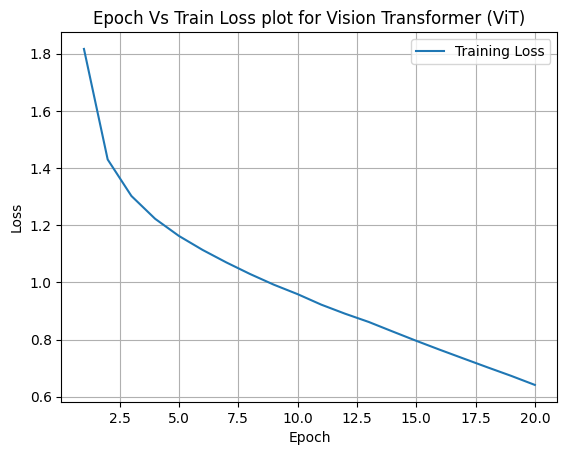

--------------------  ViT performance  --------------------
Vision transformer Train accuracy:  83.074  %
Vision transformer Test accuracy:  64.0  %
------------------------------------------------------------


In [23]:
transformer_model = ViT()
transformer_model = transformer_model.to(device)
transformer_optimizer = torch.optim.Adagrad(transformer_model.parameters(), lr=0.005)
epochs = 20
transformer_loss_function = nn.CrossEntropyLoss()

start_time = time.time()
transformer_loss_list = fit_model(model = transformer_model, train_loader = train_dataset_loader, optimizer = transformer_optimizer, 
                      loss_function = transformer_loss_function, epochs = epochs)
print(f'Execution time of ViT: { time.time() - start_time} seconds')
plot_epoch_vs_loss(np.arange(1, epochs + 1), transformer_loss_list, 'Epoch Vs Train Loss plot for Vision Transformer (ViT)')

print('-'*20, ' ViT performance ', '-'*20)
calculate_accuracy(model = transformer_model, data_loader = train_dataset_loader, title = 'Vision transformer Train accuracy: ')
calculate_accuracy(model = transformer_model, data_loader = test_dataset_loader, title = 'Vision transformer Test accuracy: ')
print('-'*60)

**Observations:**  
We observe that, 
- Cusotom CNN models requires significantly more time compared to ViT (almost 3 times more time is required).
- In the same number of epochs (=20), ViT converges faster compared to custom CNN.
- Vision Transformer performs better on both train as well as test set compared to custom CNN. 
- By tuning the hyperparameters more precisely for ViT, the ViT will surely perrform better than custom CNN.  

| Model | Train Accuracy (%) | Test Accuracy (%) | Training time (sec) |
| --- | --- | --- | --- |
| Custom CNN | 73.65 | 71.30 | 3376 |
| Vision Transformer | 83.07 | 64.00 | 1272 |